In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import pickle
from pycaret.classification import *
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc

In [6]:
# Load the dataset
data = pd.read_csv("./Web_Project/stroke_data.csv")

data

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [7]:
# Handle missing values in 'bmi' with the mean value
data['bmi'].fillna(data['bmi'].mean(), inplace=True)

In [8]:
# Encode categorical variables
categorical_features = ['gender', 'smoking_status']
label_encoders = {}
for feature in categorical_features:
    le = LabelEncoder()
    data[feature] = le.fit_transform(data[feature])
    label_encoders[feature] = le

In [9]:
# Select specific features for training
selected_features = ['gender', 'age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'smoking_status']
X = data[selected_features]
y = data['stroke']

In [10]:
# Balance the dataset using SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

In [11]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

In [12]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [15]:
# Convert categorical data
data['gender'] = data['gender'].astype('category') 
data['ever_married'] = data['ever_married'].astype('category') 
data['work_type'] = data['work_type'].astype('category') 
data['Residence_type'] = data['Residence_type'].astype('category') 
data['smoking_status'] = data['smoking_status'].astype('category')

In [17]:
# Initialize PyCaret setup

clf1 = setup(data, target='stroke', session_id=42, normalize=True, ignore_features=['id'],
             categorical_features=['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'])

 

# Compare models based on Accuracy
best_model = compare_models(sort='Accuracy', fold=5)

# Display the best model
print(best_model)

,Description,Value
0,Session id,42
1,Target,stroke
2,Target type,Binary
3,Original data shape,"(5110, 12)"
4,Transformed data shape,"(5110, 20)"
5,Transformed train set shape,"(3577, 20)"
6,Transformed test set shape,"(1533, 20)"
7,Ignore features,1
8,Numeric features,5
9,Categorical features,5


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
svm,SVM - Linear Kernel,0.9514,0.6800,0.0000,0.0000,0.0000,0.0000,0.0000,0.0680
ridge,Ridge Classifier,0.9514,0.8354,0.0000,0.0000,0.0000,0.0000,0.0000,0.0640
dummy,Dummy Classifier,0.9514,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0900
lr,Logistic Regression,0.9511,0.8397,0.0000,0.0000,0.0000,-0.0005,-0.0017,1.6400
ada,Ada Boost Classifier,0.9500,0.8000,0.0116,0.3000,0.0222,0.0176,0.0487,0.1360
rf,Random Forest Classifier,0.9497,0.8066,0.0057,0.1000,0.0108,0.0066,0.0150,0.2060
knn,K Neighbors Classifier,0.9488,0.6047,0.0230,0.3400,0.0427,0.0346,0.0748,1.2860
gbc,Gradient Boosting Classifier,0.9486,0.8344,0.0171,0.1833,0.0308,0.0230,0.0416,0.2100
lda,Linear Discriminant Analysis,0.9441,0.8353,0.0632,0.2399,0.0988,0.0797,0.0998,0.0660
et,Extra Trees Classifier,0.9435,0.7322,0.0229,0.1221,0.0383,0.0221,0.0315,0.2080


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.001, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)


In [19]:
# Train a RandomForestClassifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, n_estimators=100, n_jobs=None,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [20]:
# Make predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

In [21]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)
print('Confusion Matrix:')
print(conf_matrix)

Accuracy: 0.9434447300771208
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.94       975
           1       0.93      0.96      0.94       970

    accuracy                           0.94      1945
   macro avg       0.94      0.94      0.94      1945
weighted avg       0.94      0.94      0.94      1945

Confusion Matrix:
[[902  73]
 [ 37 933]]


In [22]:
# Create a table showing correct and incorrect predictions
prediction_table = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
correct_predictions = prediction_table[prediction_table['Actual'] == prediction_table['Predicted']]
incorrect_predictions = prediction_table[prediction_table['Actual'] != prediction_table['Predicted']]

print('Correct Predictions:')
print(correct_predictions.value_counts())
print('Incorrect Predictions:')
print(incorrect_predictions.value_counts())

Correct Predictions:
Actual  Predicted
1       1            933
0       0            902
Name: count, dtype: int64
Incorrect Predictions:
Actual  Predicted
0       1            73
1       0            37
Name: count, dtype: int64


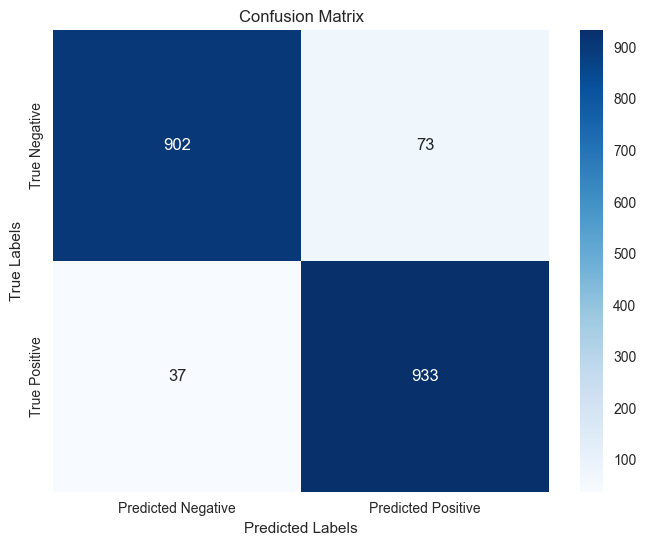

In [23]:
# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['True Negative', 'True Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

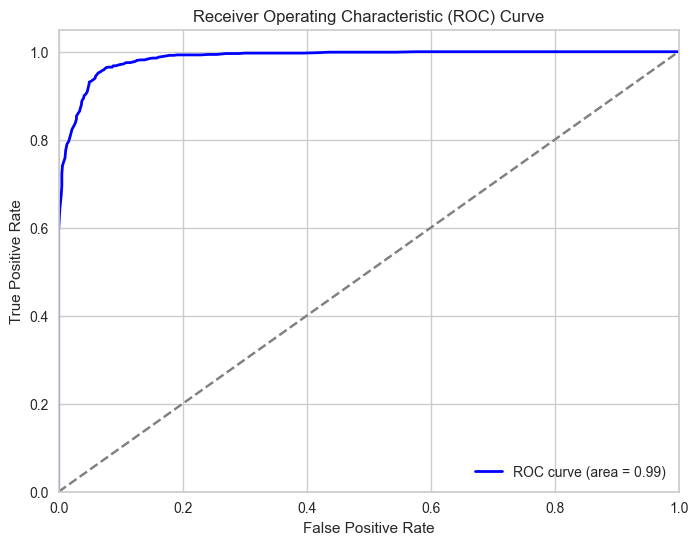

In [29]:
# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


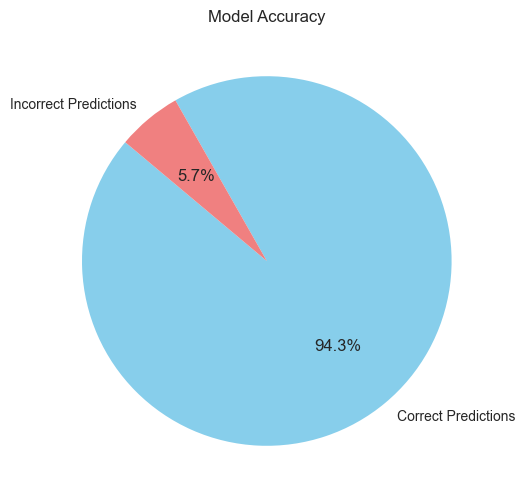

In [33]:
# Plot Accuracy as a Pie Chart
plt.figure(figsize=(8, 6))
accuracy_score_plot = [accuracy, 1 - accuracy]
plt.pie(accuracy_score_plot, labels=['Correct Predictions', 'Incorrect Predictions'], autopct='%1.1f%%', colors=['skyblue', 'lightcoral'], startangle=140)
plt.title('Model Accuracy')
plt.show()

In [ ]:
# Save the model, scaler, and label encoders
with open('stroke_prediction_model.pkl', 'wb') as file:
    pickle.dump(model, file)

with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

with open('label_encoders.pkl', 'wb') as file:
    pickle.dump(label_encoders, file)